In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
df1 = pd.read_csv("firstpage.csv")
df2 = pd.read_csv("secondpage.csv")
df3 = pd.read_csv("thirdpage.csv")
df4 = pd.read_csv("fourthpage.csv")
df5 = pd.read_csv("fifthpage.csv")
df6 = pd.read_csv("sixthpage.csv")
df7 = pd.read_csv("seventhpage.csv")

In [3]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7])
df.set_index('movie_title', inplace=True)
df

,runtime,genres,rating,domestic_box_office,international_box_office,domestic_opening_weekend,budget,release_date,criticscore,director,actors
movie_title,,,,,,,,,,,
Star Wars: Episode VII - The Force Awakens,138,"['Action', 'Adventure', 'Sci-Fi']",PG-13,936662225,1131793436,247966675,245000000,2015-12-18,80,J.J. Abrams,"['Daisy Ridley', 'John Boyega', 'Oscar Isaac']"
Avengers: Endgame,181,"['Action', 'Adventure', 'Drama', 'Sci-Fi']",PG-13,858373000,1939128328,357115007,356000000,2019-04-26,78,NaN,"['Robert Downey Jr.', 'Chris Evans', 'Mark Ruf..."
Avatar,162,"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",PG-13,760507625,2083806217,77025481,237000000,2009-12-18,83,James Cameron,"['Sam Worthington', 'Zoe Saldana', 'Sigourney ..."
Black Panther,134,"['Action', 'Adventure', 'Sci-Fi']",PG-13,700426566,647171407,202003951,700059566,2018-02-16,88,Ryan Coogler,"['Chadwick Boseman', 'Michael B. Jordan', ""Lup..."
Avengers: Infinity War,149,"['Action', 'Adventure', 'Sci-Fi']",PG-13,678815482,1369544272,257698183,678815482,2018-04-27,68,NaN,"['Robert Downey Jr.', 'Chris Hemsworth', 'Mark..."
...,...,...,...,...,...,...,...,...,...,...,...
The Hate U Give,133,"['Crime', 'Drama']",PG-13,29719483,5214526,512035,23000000,2018-10-19,81,George Tillman Jr.,"['Amandla Stenberg', 'Regina Hall', 'Russell H..."
When the Bough Breaks,107,"['Drama', 'Thriller']",PG-13,29747603,910784,14202323,10000000,2016-09-09,28,Jon Cassar,"['Morris Chestnut', 'Regina Hall', 'Romany Mal..."
Did You Hear About the Morgans?,103,"['Comedy', 'Drama', 'Romance']",PG-13,29580087,55700163,6616571,58000000,2009-12-18,27,Marc Lawrence,"['Hugh Grant', 'Sarah Jessica Parker', 'Sam El..."


In [4]:
df.dropna(inplace=True)

In [5]:
df['genres'] = df['genres'].str.replace('Action','Adventure')

In [6]:
df['genres'] = df['genres'].str[1:-1]
df['genres_1'] = df.genres.str.split().str.get(0)
df['genres_1'] = df['genres_1'].map(lambda x: str(x))

In [7]:
df["genres_1"] = df["genres_1"].str.replace(",", "").replace("''", "")
df["genres_1"].value_counts()

'Adventure'    710
'Comedy'       391
'Drama'        182
'Biography'     88
'Horror'        74
'Crime'         68
'Animation'     12
'Thriller'       6
'Fantasy'        5
'Mystery'        4
'Sci-Fi'         1
'Romance'        1
'Family'         1
Name: genres_1, dtype: int64

In [8]:
df['months'] = pd.DatetimeIndex(df['release_date']).month

In [9]:
df = df.reset_index()
df

,movie_title,runtime,genres,rating,domestic_box_office,international_box_office,domestic_opening_weekend,budget,release_date,criticscore,director,actors,genres_1,months
0,Star Wars: Episode VII - The Force Awakens,138,"'Adventure', 'Adventure', 'Sci-Fi'",PG-13,936662225,1131793436,247966675,245000000,2015-12-18,80,J.J. Abrams,"['Daisy Ridley', 'John Boyega', 'Oscar Isaac']",'Adventure',12
1,Avatar,162,"'Adventure', 'Adventure', 'Fantasy', 'Sci-Fi'",PG-13,760507625,2083806217,77025481,237000000,2009-12-18,83,James Cameron,"['Sam Worthington', 'Zoe Saldana', 'Sigourney ...",'Adventure',12
2,Black Panther,134,"'Adventure', 'Adventure', 'Sci-Fi'",PG-13,700426566,647171407,202003951,700059566,2018-02-16,88,Ryan Coogler,"['Chadwick Boseman', 'Michael B. Jordan', ""Lup...",'Adventure',2
3,Jurassic World,124,"'Adventure', 'Adventure', 'Sci-Fi'",PG-13,652385625,1018130819,208806270,150000000,2015-06-12,59,Colin Trevorrow,"['Chris Pratt', 'Bryce Dallas Howard', 'Ty Sim...",'Adventure',6
4,The Avengers,143,"'Adventure', 'Adventure', 'Sci-Fi'",PG-13,623357910,895457605,207438708,220000000,2012-05-04,69,Joss Whedon,"['Robert Downey Jr.', 'Chris Evans', 'Scarlett...",'Adventure',5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,Grudge Match,113,"'Comedy', 'Drama', 'Sport'",PG-13,29807260,15100000,7021993,40000000,2013-12-25,35,Peter Segal,"['Robert De Niro', 'Sylvester Stallone', 'Kim ...",'Comedy',12
1539,The Hate U Give,133,"'Crime', 'Drama'",PG-13,29719483,5214526,512035,23000000,2018-10-19,81,George Tillman Jr.,"['Amandla Stenberg', 'Regina Hall', 'Russell H...",'Crime',10
1540,When the Bough Breaks,107,"'Drama', 'Thriller'",PG-13,29747603,910784,14202323,10000000,2016-09-09,28,Jon Cassar,"['Morris Chestnut', 'Regina Hall', 'Romany Mal...",'Drama',9
1541,Did You Hear About the Morgans?,103,"'Comedy', 'Drama', 'Romance'",PG-13,29580087,55700163,6616571,58000000,2009-12-18,27,Marc Lawrence,"['Hugh Grant', 'Sarah Jessica Parker', 'Sam El...",'Comedy',12


In [10]:
counts = df['genres_1'].value_counts()
idx = counts[counts.lt(100)].index

df.loc[df['genres_1'].isin(idx), 'genres_1'] = 'Others'

In [11]:
genre_counts = df.genres_1.value_counts()
genre_counts

'Adventure'    710
'Comedy'       391
Others         260
'Drama'        182
Name: genres_1, dtype: int64

In [12]:
df.corr()

,domestic_box_office,international_box_office,domestic_opening_weekend,budget,months
domestic_box_office,1.000000,0.830531,0.885162,0.636609,0.091087
international_box_office,0.830531,1.000000,0.764735,0.700214,0.110670
domestic_opening_weekend,0.885162,0.764735,1.000000,0.649471,0.005862
budget,0.636609,0.700214,0.649471,1.000000,0.078418
months,0.091087,0.110670,0.005862,0.078418,1.000000


In [13]:
genre_dummies = pd.get_dummies(df['genres_1']) 
genre_dummies = genre_dummies.drop(["Others"], axis=1)
genre_dummies.rename(columns={"'Adventure'": "Adventure", "'Comedy'": "Comedy", "'Drama'": "Drama"}, inplace=True)
genre_dummies 

,Adventure,Comedy,Drama
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
1538,0,1,0
1539,0,0,0
1540,0,0,1
1541,0,1,0


In [14]:
rating_dummies = pd.get_dummies(df['rating'])
rating_dummies = rating_dummies.drop(["R"], axis=1)
rating_dummies

,G,PG,PG-13
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
1538,0,0,1
1539,0,0,1
1540,0,0,1
1541,0,0,1


In [15]:
df = pd.concat([df, rating_dummies], axis=1)

In [16]:
df = pd.concat([df, genre_dummies], axis=1)

In [17]:
df

,movie_title,runtime,genres,rating,domestic_box_office,international_box_office,domestic_opening_weekend,budget,release_date,criticscore,director,actors,genres_1,months,G,PG,PG-13,Adventure,Comedy,Drama
0,Star Wars: Episode VII - The Force Awakens,138,"'Adventure', 'Adventure', 'Sci-Fi'",PG-13,936662225,1131793436,247966675,245000000,2015-12-18,80,J.J. Abrams,"['Daisy Ridley', 'John Boyega', 'Oscar Isaac']",'Adventure',12,0,0,1,1,0,0
1,Avatar,162,"'Adventure', 'Adventure', 'Fantasy', 'Sci-Fi'",PG-13,760507625,2083806217,77025481,237000000,2009-12-18,83,James Cameron,"['Sam Worthington', 'Zoe Saldana', 'Sigourney ...",'Adventure',12,0,0,1,1,0,0
2,Black Panther,134,"'Adventure', 'Adventure', 'Sci-Fi'",PG-13,700426566,647171407,202003951,700059566,2018-02-16,88,Ryan Coogler,"['Chadwick Boseman', 'Michael B. Jordan', ""Lup...",'Adventure',2,0,0,1,1,0,0
3,Jurassic World,124,"'Adventure', 'Adventure', 'Sci-Fi'",PG-13,652385625,1018130819,208806270,150000000,2015-06-12,59,Colin Trevorrow,"['Chris Pratt', 'Bryce Dallas Howard', 'Ty Sim...",'Adventure',6,0,0,1,1,0,0
4,The Avengers,143,"'Adventure', 'Adventure', 'Sci-Fi'",PG-13,623357910,895457605,207438708,220000000,2012-05-04,69,Joss Whedon,"['Robert Downey Jr.', 'Chris Evans', 'Scarlett...",'Adventure',5,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,Grudge Match,113,"'Comedy', 'Drama', 'Sport'",PG-13,29807260,15100000,7021993,40000000,2013-12-25,35,Peter Segal,"['Robert De Niro', 'Sylvester Stallone', 'Kim ...",'Comedy',12,0,0,1,0,1,0
1539,The Hate U Give,133,"'Crime', 'Drama'",PG-13,29719483,5214526,512035,23000000,2018-10-19,81,George Tillman Jr.,"['Amandla Stenberg', 'Regina Hall', 'Russell H...",Others,10,0,0,1,0,0,0
1540,When the Bough Breaks,107,"'Drama', 'Thriller'",PG-13,29747603,910784,14202323,10000000,2016-09-09,28,Jon Cassar,"['Morris Chestnut', 'Regina Hall', 'Romany Mal...",'Drama',9,0,0,1,0,0,1
1541,Did You Hear About the Morgans?,103,"'Comedy', 'Drama', 'Romance'",PG-13,29580087,55700163,6616571,58000000,2009-12-18,27,Marc Lawrence,"['Hugh Grant', 'Sarah Jessica Parker', 'Sam El...",'Comedy',12,0,0,1,0,1,0


In [32]:
df.corr()

,runtime,domestic_box_office,international_box_office,domestic_opening_weekend,budget,criticscore,months,G,PG,PG-13,Adventure,Comedy,Drama,directors_1
runtime,1.000000,0.350381,0.389054,0.268541,0.381084,0.395264,0.112919,-0.093654,-0.215731,0.120479,0.124609,-0.232956,0.096905,0.316208
domestic_box_office,0.350381,1.000000,0.831046,0.886355,0.637039,0.273953,0.087834,0.036044,0.030479,0.129471,0.276794,-0.154937,-0.095910,0.369211
international_box_office,0.389054,0.831046,1.000000,0.764448,0.698354,0.209046,0.107463,0.038679,0.017763,0.142284,0.368700,-0.238224,-0.100549,0.320875
domestic_opening_weekend,0.268541,0.886355,0.764448,1.000000,0.647697,0.114550,0.002319,0.028748,-0.008019,0.156585,0.328076,-0.178010,-0.124561,0.329275
budget,0.381084,0.637039,0.698354,0.647697,1.000000,0.095298,0.073677,0.026018,0.059315,0.172626,0.481593,-0.259528,-0.143629,0.370478
criticscore,0.395264,0.273953,0.209046,0.114550,0.095298,1.000000,0.131976,0.003209,-0.067786,-0.092201,-0.014348,-0.138608,0.077529,0.146255
months,0.112919,0.087834,0.107463,0.002319,0.073677,0.131976,1.000000,0.033389,0.010841,0.009048,-0.051117,0.021717,-0.014521,0.058519
G,-0.093654,0.036044,0.038679,0.028748,0.026018,0.003209,0.033389,1.000000,-0.045685,-0.106420,0.034121,-0.001130,-0.037829,-0.024972
PG,-0.215731,0.030479,0.017763,-0.008019,0.059315,-0.067786,0.010841,-0.045685,1.000000,-0.456709,0.129933,-0.046681,-0.068811,-0.024323
PG-13,0.120479,0.129471,0.142284,0.156585,0.172626,-0.092201,0.009048,-0.106420,-0.456709,1.000000,0.017671,0.065036,0.062014,0.113715


In [19]:
df['domestic_box_office'] = df['domestic_box_office'].apply(lambda x: x/1000000)
df['domestic_opening_weekend'] = df['domestic_opening_weekend'].apply(lambda x: x/1000000)
df['international_box_office'] = df['international_box_office'].apply(lambda x: x/1000000)
df['budget'] = df['budget'].apply(lambda x: x/1000000)

In [20]:
df = df[df['criticscore'].apply(lambda x: str(x).isdigit())]
df = df[df['runtime'].apply(lambda x: str(x).isdigit())]

In [21]:
df["criticscore"] = pd.to_numeric(df['criticscore'])
df["runtime"] = pd.to_numeric(df['runtime'])

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1519 entries, 0 to 1542
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   movie_title               1519 non-null   object 
 1   runtime                   1519 non-null   int64  
 2   genres                    1519 non-null   object 
 3   rating                    1519 non-null   object 
 4   domestic_box_office       1519 non-null   float64
 5   international_box_office  1519 non-null   float64
 6   domestic_opening_weekend  1519 non-null   float64
 7   budget                    1519 non-null   float64
 8   release_date              1519 non-null   object 
 9   criticscore               1519 non-null   int64  
 10  director                  1519 non-null   object 
 11  actors                    1519 non-null   object 
 12  genres_1                  1519 non-null   object 
 13  months                    1519 non-null   int64  
 14  G       

In [33]:
#looking at a smaller subset of features
subset=['domestic_box_office', 'domestic_opening_weekend', 'runtime', 'budget', 'criticscore', 'months', 'international_box_office', 'Adventure', 'Comedy', 'Drama', 'G','PG','PG-13', 'directors_1']
smaller_df=df.loc[:,subset]

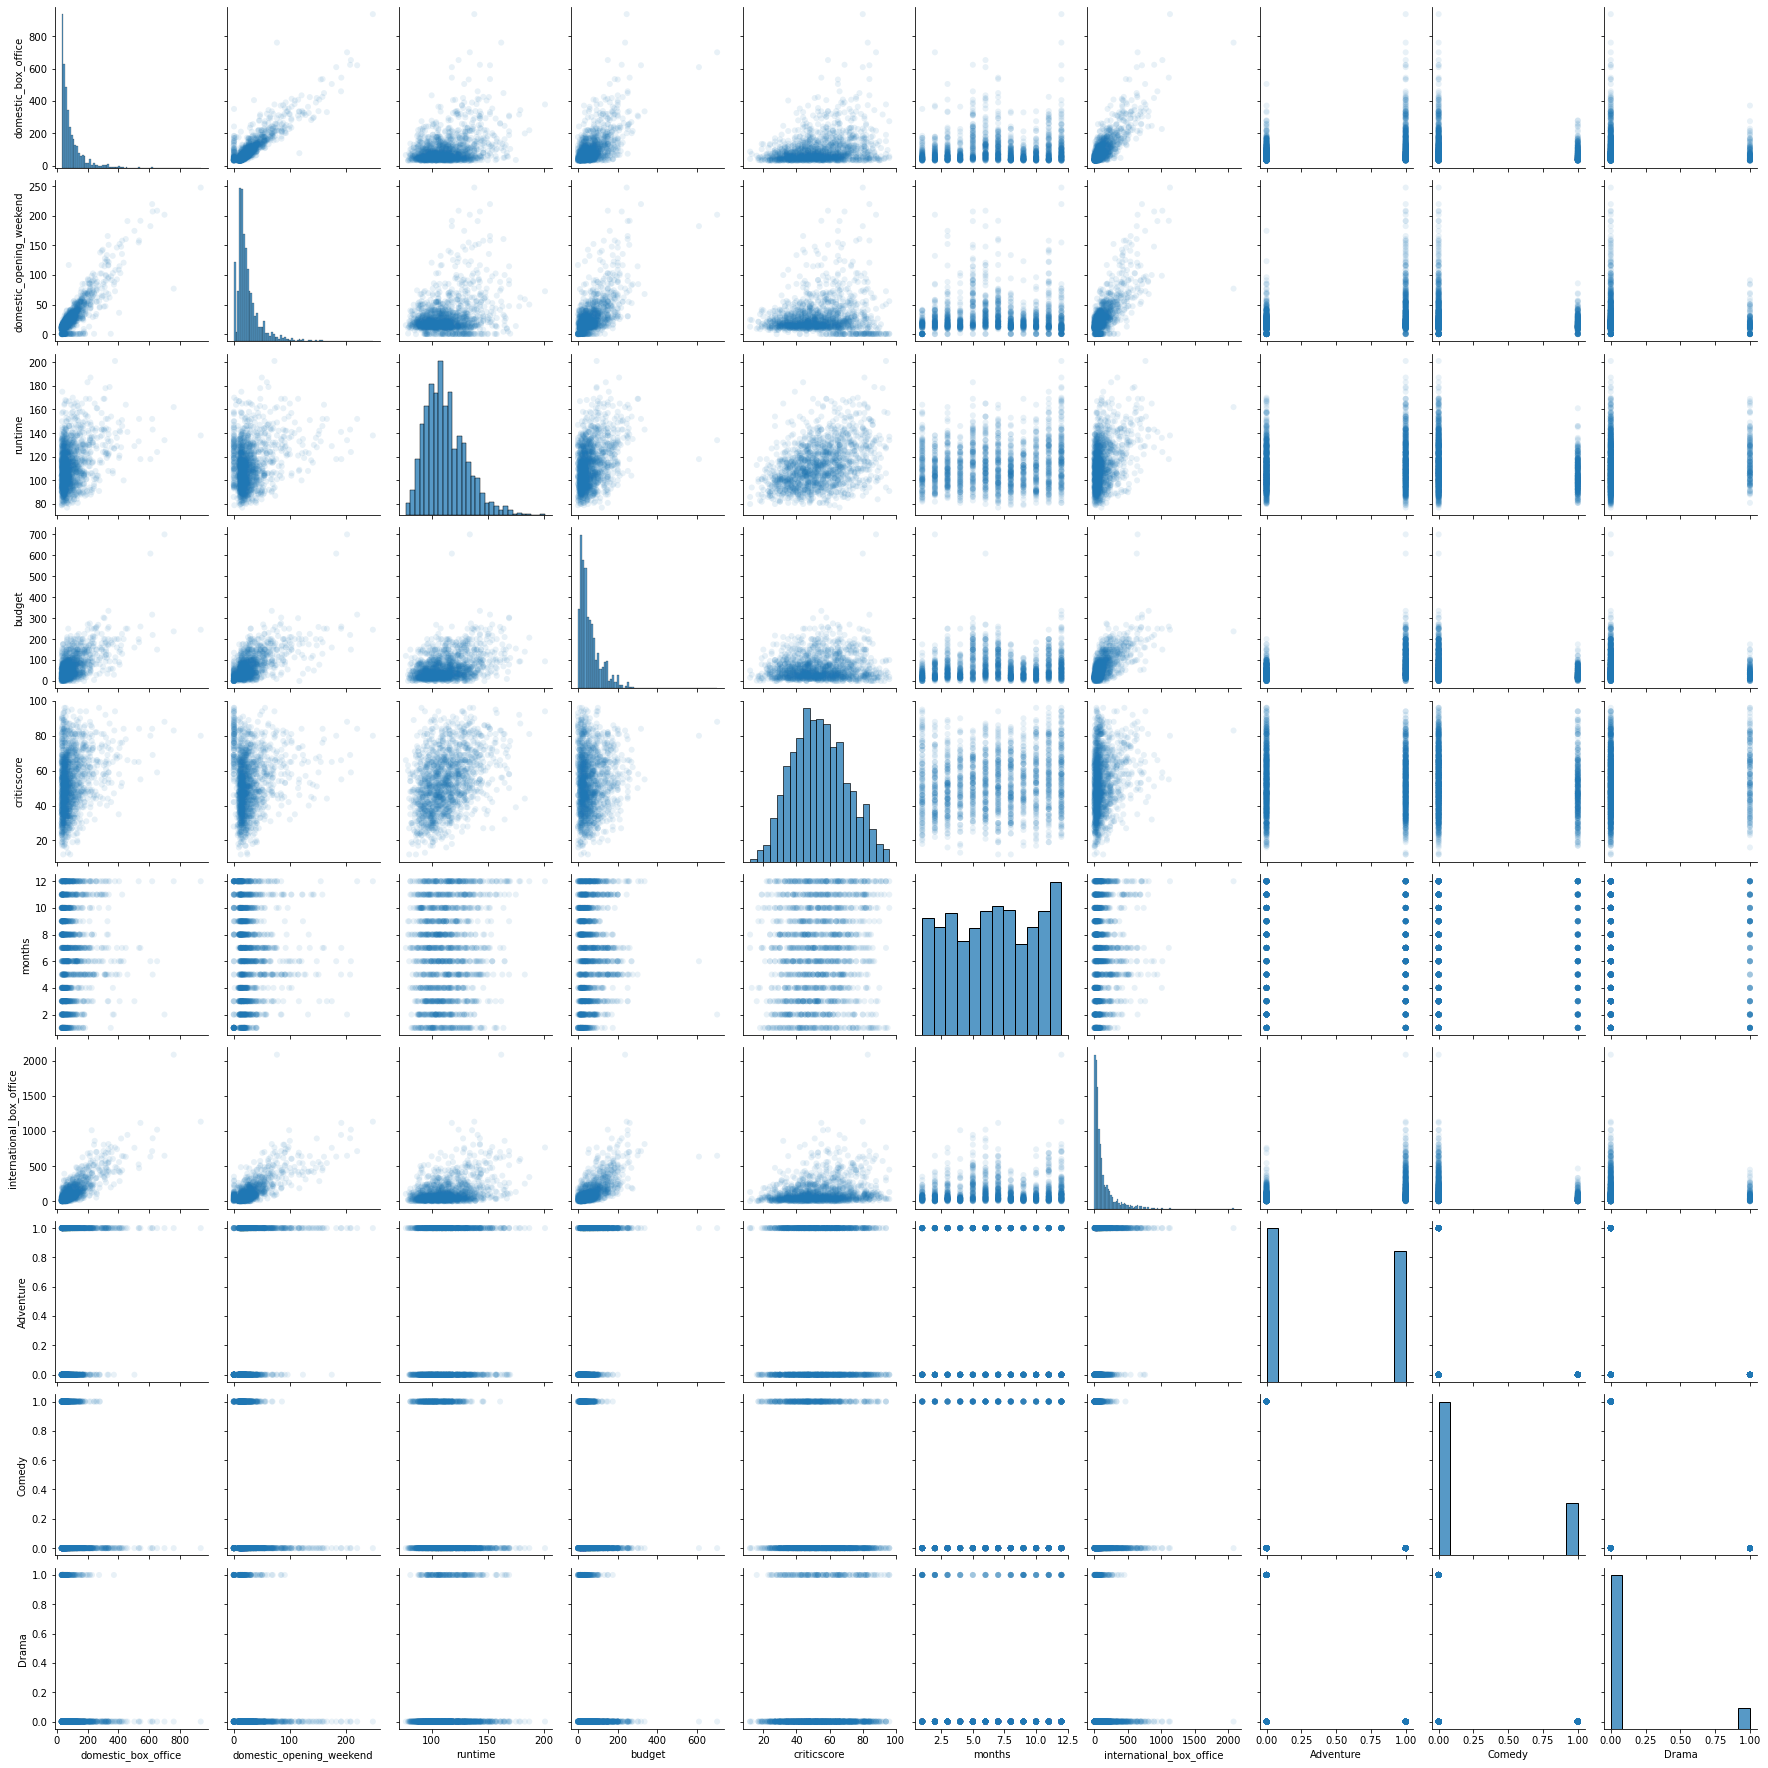

In [27]:
sns.pairplot(smaller_df, plot_kws=dict(alpha=.1, edgecolor='none'))

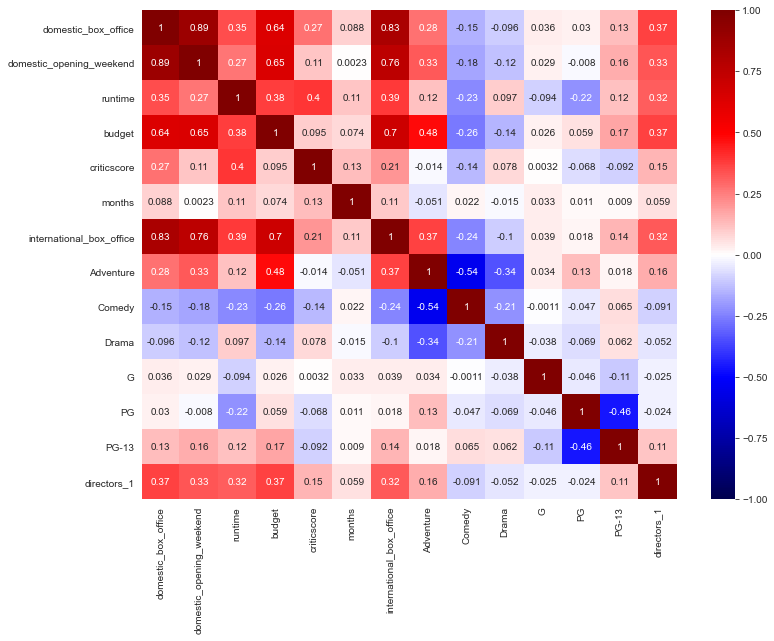

In [36]:
plt.figure(figsize=(12, 9))
sns.heatmap(smaller_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);
plt.savefig('heat_map.png', bbox_inches="tight")

Text(0, 0.5, 'international box office')

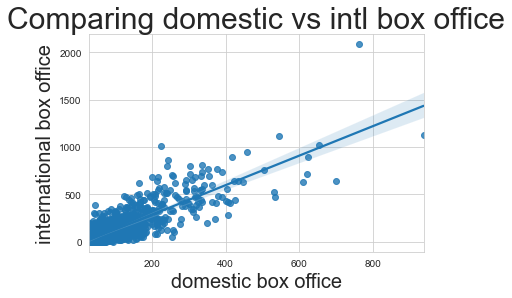

In [34]:
sns.set_style('whitegrid') 
sns.regplot(data = df, x = 'domestic_box_office', y = 'international_box_office');
plt.title('Comparing domestic vs intl box office', fontsize = 30);
plt.xlabel( "domestic box office" , size = 20 ) 
plt.ylabel( "international box office" , size = 20 ) 

Text(0, 0.5, 'international box office')

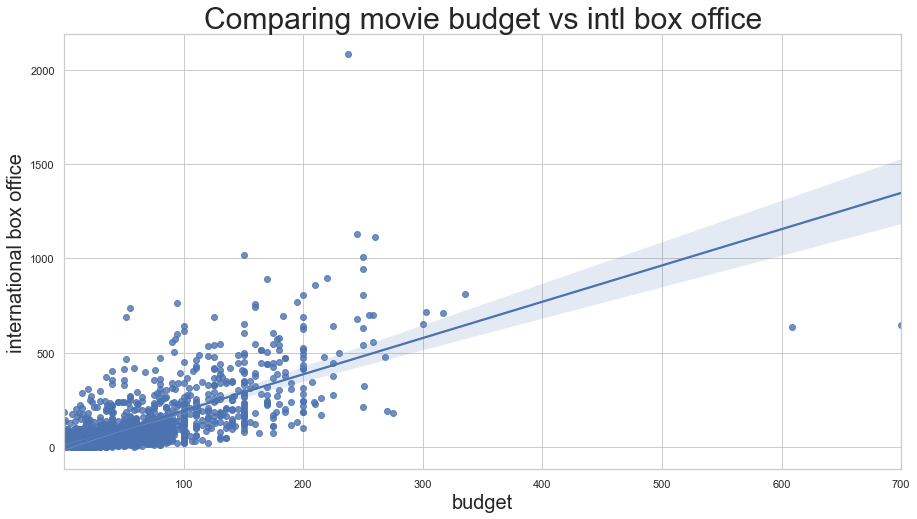

In [299]:
sns.set_style('whitegrid') 
sns.regplot(data = df, x = 'budget', y = 'international_box_office');
plt.title('Comparing movie budget vs intl box office', fontsize = 30);
plt.xlabel( "budget" , size = 20 ) 
plt.ylabel( "international box office" , size = 20 ) 

In [91]:
#MODEL ONE -- OLS with all features
lm1 = smf.ols('international_box_office ~ domestic_box_office + domestic_opening_weekend + runtime \
            + budget + criticscore + months + Adventure + Comedy + Drama + G + PG + directors_1', data=df)

fit1 = lm1.fit()

fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     international_box_office   R-squared:                       0.750
Model:                                  OLS   Adj. R-squared:                  0.748
Method:                       Least Squares   F-statistic:                     376.7
Date:                      Wed, 14 Apr 2021   Prob (F-statistic):               0.00
Time:                              21:33:56   Log-Likelihood:                -8824.8
No. Observations:                      1519   AIC:                         1.768e+04
Df Residuals:                          1506   BIC:                         1.774e+04
Df Model:                                12                                         
Covariance Type:                  nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 -106.8134     16.594     -6.437      0.000    -139.362     -74.264
domestic_box_office          1.1888      0.059     20.126      0.000       1.073       1.305
domestic_opening_weekend     0.1487      0.178      0.833      0.405      -0.201       0.499
runtime                      0.6602      0.146      4.527      0.000       0.374       0.946
budget                       0.6313      0.054     11.614      0.000       0.525       0.738
criticscore                 -0.2225      0.149     -1.496      0.135      -0.514       0.069
months                       1.6078      0.607      2.647      0.008       0.416       2.799
Adventure                   17.1199      6.523      2.625      0.009       4.325      29.914
Comedy                     -14.2784      6.699     -2.131      0.033     -27.419      -1.138
Drama                       -0.6663      7.942     -0.084      0.933     -16.244      14.912
G                           18.3626     20.650      0.889      0.374     -22.143      58.868
PG                          -4.3948      5.951     -0.739      0.460     -16.068       7.278
directors_1                -14.2485      5.070     -2.810      0.005     -24.193      -4.304
==============================================================================
Omnibus:                      809.317   Durbin-Watson:                   2.218
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34756.383
Skew:                           1.789   Prob(JB):                         0.00
Kurtosis:                      26.159   Cond. No.                     1.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [322]:
features, target = [['domestic_box_office', 'domestic_opening_weekend','runtime', 'budget', 'criticscore', 'months', 'Adventure', "Comedy", "Drama"], 'international_box_office']
X, y = df[features], df[target]

lm = LinearRegression() 
lm.fit(X, y) 

print(lm.intercept_)
print(lm.coef_)
print(lm.score(X,y))

-102.78582911155611
[  1.16910498   0.17008106   0.60609366   0.60851586  -0.21981992
   1.61063565  16.7882175  -14.5737159   -0.33404806]
0.748540992869013


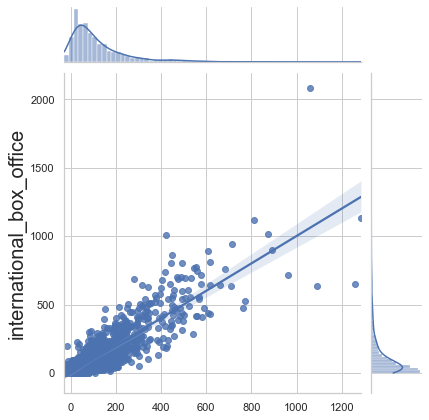

In [323]:
preds = lm.predict(X) 

sns.jointplot(x=preds,y=y, kind='reg')

plt.savefig('OLS_plot.png')

In [324]:
rmse = mean_squared_error(y, preds, squared=False)
mae = mean_absolute_error(y, preds)

print(rmse)
print(mae)

80.94845606344741
50.8581393332968


In [275]:
#MODEL TWO -- OLS without domestic box office/weekend and other genres
lm1 = smf.ols('international_box_office ~ runtime \
            + budget + criticscore + months + Adventure', data=df)

fit1 = lm1.fit()

fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     international_box_office   R-squared:                       0.519
Model:                                  OLS   Adj. R-squared:                  0.518
Method:                       Least Squares   F-statistic:                     327.0
Date:                      Tue, 13 Apr 2021   Prob (F-statistic):          1.15e-237
Time:                              13:40:50   Log-Likelihood:                -9321.6
No. Observations:                      1519   AIC:                         1.866e+04
Df Residuals:                          1513   BIC:                         1.869e+04
Df Model:                                 5                                         
Covariance Type:                  nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -162.4319     19.224     -8.449      0.000    -200.141    -124.723
runtime         0.8864      0.187      4.738      0.000       0.519       1.253
budget          1.7009      0.061     28.101      0.000       1.582       1.820
criticscore     1.0537      0.193      5.451      0.000       0.675       1.433
months          1.8289      0.830      2.204      0.028       0.201       3.457
Adventure      20.2873      6.637      3.057      0.002       7.268      33.306
==============================================================================
Omnibus:                     1168.493   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63349.378
Skew:                           3.077   Prob(JB):                         0.00
Kurtosis:                      34.033   Cond. No.                         967.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [300]:
features, target = [['runtime', 'budget', 'criticscore', 'months', 'Adventure'], 'international_box_office']
X, y = df[features], df[target]

lm = LinearRegression() 
lm.fit(X, y) 

print(lm.intercept_)
print(lm.coef_)
print(lm.score(X,y))

-162.43191619111184
[ 0.88643491  1.70089611  1.05370314  1.82890548 20.28731652]
0.5193664956445148


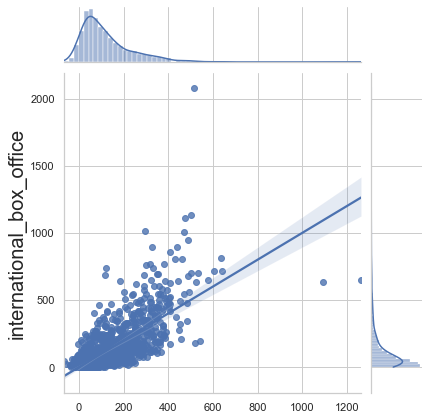

In [301]:
preds = lm.predict(X) 

sns.jointplot(x=preds,y=y, kind='reg')

In [302]:
rmse = mean_squared_error(y, preds, squared=False)
mae = mean_absolute_error(y, preds)

print(rmse)
print(mae)

111.91337483783231
69.41029814125609


In [312]:
#MODEL THREE POLYNOMIAL REG
features, target = [['runtime', 'budget', 'criticscore', 'months', 'Adventure'], 'international_box_office']
X, y = df[features], df[target]

In [313]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y) 

poly = PolynomialFeatures(degree=2) 
X_poly = poly.fit_transform(X.values)

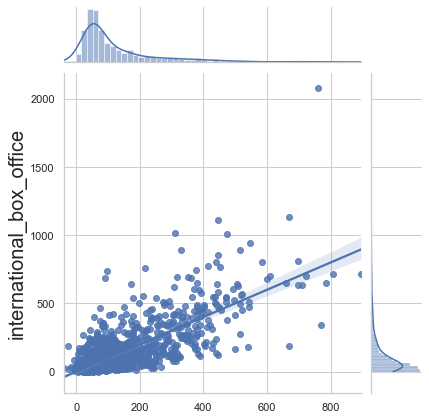

In [306]:
preds = lm_poly.predict(X_poly) 

sns.jointplot(x=preds,y=y, kind='reg')

In [327]:
rmse = mean_squared_error(y, preds, squared=False)
mae = mean_absolute_error(y, preds)

print(rmse)
print(mae)

print(lm_poly.intercept_)
print(lm_poly.coef_)
#print(lm_poly.score(X,y))

80.94845606344741
50.8581393332968
248.70838572424992
[ 0.00000000e+00 -2.55145647e+00 -1.35311585e+00 -6.58410622e-01
 -1.19190095e+01 -3.43815863e+01  7.49441305e-03  1.53844616e-02
 -6.45665837e-03  7.04577635e-02  1.83123338e-01 -3.00808190e-03
  1.72207155e-02  3.03772978e-02  9.80852462e-01  1.28694213e-02
  2.60729636e-02  8.02597029e-02  1.29885874e-01  1.44260300e+00
 -3.43815863e+01]


In [28]:
directorslist_df = pd.read_pickle("directorslist.pkl")

In [29]:
directorslist_df

,directors
0,Steven Spielberg
1,Michael Bay
2,Anthony Russo
3,Joe Russo
4,J.J. Abrams
...,...
95,Stephen Sommers
96,Peyton Reed
97,Adam McKay
98,Mike Mitchell


In [30]:
df["directors_1"] = np.nan

In [31]:
df['directors_1'] = df.director.isin(directorslist_df.directors).astype(int)

In [87]:
df['actors']

0          ['Daisy Ridley', 'John Boyega', 'Oscar Isaac']
1       ['Sam Worthington', 'Zoe Saldana', 'Sigourney ...
2       ['Chadwick Boseman', 'Michael B. Jordan', "Lup...
3       ['Chris Pratt', 'Bryce Dallas Howard', 'Ty Sim...
4       ['Robert Downey Jr.', 'Chris Evans', 'Scarlett...
                              ...                        
1538    ['Robert De Niro', 'Sylvester Stallone', 'Kim ...
1539    ['Amandla Stenberg', 'Regina Hall', 'Russell H...
1540    ['Morris Chestnut', 'Regina Hall', 'Romany Mal...
1541    ['Hugh Grant', 'Sarah Jessica Parker', 'Sam El...
1542       ['Tom Welling', 'Maggie Grace', 'Selma Blair']
Name: actors, Length: 1519, dtype: object

In [42]:
actorslist_df = pd.read_pickle("actorslist.pkl")

In [43]:
actorslist_df

,actors
0,Samuel L. Jackson
1,"Robert Downey, Jr."
2,Tom Hanks
3,Scarlett Johansson
4,Bradley Cooper
...,...
95,Michelle Pfeiffer
96,Martin Freeman
97,Chris Pine
98,Steve Martin


In [44]:
actorslist = actorslist_df['actors'].to_list()

In [45]:
actorslist

['Samuel L. Jackson',
 'Robert Downey, Jr.',
 'Tom Hanks',
 'Scarlett Johansson',
 'Bradley Cooper',
 'Harrison Ford',
 'Chris Evans',
 'Chris Hemsworth',
 'Zoe Saldana',
 'Chris Pratt',
 'Tom Cruise',
 'Johnny Depp',
 'Eddie Murphy',
 'Will Smith',
 'Mark Ruffalo',
 'Don Cheadle',
 'Vin Diesel',
 'Matt Damon',
 'Jeremy Renner',
 'Dwayne Johnson',
 'Emma Watson',
 'Adam Sandler',
 'Chadwick Boseman',
 'Bruce Willis',
 'Ben Stiller',
 'Nicolas Cage',
 'Karen Gillan',
 'Steve Carell',
 'Jim Carrey',
 'Leonardo DiCaprio',
 'Josh Brolin',
 'Jennifer Lawrence',
 'Robin Williams',
 'Liam Neeson',
 'Benedict Cumberbatch',
 'Robert De Niro',
 'Tom Holland',
 'Daniel Radcliffe',
 'Hugh Jackman',
 'Sandra Bullock',
 'Brad Pitt',
 'Gwyneth Paltrow',
 'Cameron Diaz',
 'Denzel Washington',
 'Ian McKellen',
 'Elizabeth Olsen',
 'Sebastian Stan',
 'Dave Bautista',
 'Tom Hiddleston',
 'Rupert Grint',
 'Ben Affleck',
 'Paul Bettany',
 'Julia Roberts',
 'Ewan McGregor',
 'Mel Gibson',
 'Kevin Hart',
 'J

In [57]:
def actor_count(list_of_actors):
    count = 0
    for actor in list_of_actors:
        if actor in actorslist:
            count += 1
    return count

df['actors_1'] = df['actors'].apply(actor_count)

In [58]:
df["actors_1"].value_counts()

0    1543
Name: actors_1, dtype: int64

In [29]:
df.to_pickle("main_movie_df.pkl")